# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shivanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_csv('preprocessed_data.csv')

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [3]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
y = data['project_is_approved'].values
x = data.drop(['project_is_approved'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [4]:
sid = SentimentIntensityAnalyzer()

essays_train = X_train['essay']
compound_train_sentiments = []
neg_train_sentiments = []
neu_train_sentiments = []
pos_train_sentiments = []
for essay in tqdm(essays_train):
    res = sid.polarity_scores(essay)
    compound_train_sentiments.append(res['compound'])
    neg_train_sentiments.append(res['neg'])
    neu_train_sentiments.append(res['neu'])
    pos_train_sentiments.append(res['pos'])


essays_test = X_test['essay']
compound_test_sentiments = []
neg_test_sentiments = []
neu_test_sentiments = []
pos_test_sentiments = []
for essay in tqdm(essays_test):
    res = sid.polarity_scores(essay)
    compound_test_sentiments.append(res['compound'])
    neg_test_sentiments.append(res['neg'])
    neu_test_sentiments.append(res['neu'])
    pos_test_sentiments.append(res['pos'])


100%|██████████| 36052/36052 [01:04<00:00, 558.31it/s]


In [8]:
compound_train_sentiments = np.array(compound_train_sentiments).reshape(-1,1)
neg_train_sentiments = np.array(neg_train_sentiments).reshape(-1,1)
neu_train_sentiments = np.array(neu_train_sentiments).reshape(-1,1)
pos_train_sentiments = np.array(pos_train_sentiments).reshape(-1,1)

compound_test_sentiments = np.array(compound_test_sentiments).reshape(-1,1)
neg_test_sentiments = np.array(neg_test_sentiments).reshape(-1,1)
neu_test_sentiments = np.array(neu_test_sentiments).reshape(-1,1)
pos_test_sentiments = np.array(pos_test_sentiments).reshape(-1,1)

### For Set 1 - Essay -> TFIDF

In [5]:
vectorizer_essay = TfidfVectorizer(min_df = 10, ngram_range=(1,4))
vectorizer_essay.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer_essay.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_essay.transform(X_test['essay'].values)
print("After applying tfidf on essay : ")
print(X_train_essay_tfidf.shape, y_train.shape)
# print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After applying tfidf on essay : 
(73196, 257622) (73196,)
(36052, 257622) (36052,)


### For Set 2 - Essay -> TFIDF_W2V 

In [14]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

X_train_essay_tfidfw2v = []

for sen in tqdm(X_train['essay']):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sen.split():
        if(word in glove_words and word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sen.count(word)/len(sen.split()))
            vector += (vec*tf_idf)
            tf_idf_weight += tf_idf
    if(tf_idf_weight != 0):
        vector = vector/tf_idf_weight
    X_train_essay_tfidfw2v.append(vector)

X_test_essay_tfidfw2v = []

for sen in tqdm(X_test['essay']):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sen.split():
        if(word in glove_words and word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sen.count(word)/len(sen.split()))
            vector += (vec*tf_idf)
            tf_idf_weight += tf_idf
    if(tf_idf_weight != 0):
        vector = vector/tf_idf_weight
    X_test_essay_tfidfw2v.append(vector)

100%|██████████| 36052/36052 [01:31<00:00, 395.20it/s]


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [6]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()


X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.fit_transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)

print("Normalized Price :")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)



Normalized Price :
(73196, 1) (73196,)
(36052, 1) (36052,)


In [7]:
normalizer = Normalizer()

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.fit_transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm = X_train_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
X_test_teacher_number_of_previously_posted_projects_norm = X_test_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)


print("Normalized teacher_number_of_previously_posted_projects :")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)

Normalized teacher_number_of_previously_posted_projects :
(73196, 1) (73196,)
(36052, 1) (36052,)


In [9]:
categorical_data = ['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']

In [10]:
def get_fea_dict(feature, x_df, y_df):
    value_count = x_df[feature].value_counts()
    feat_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(0, 2):
            cls_cnt = x_df.loc[(y_df==k) & (x_df[feature]==i)]
            vec.append((cls_cnt.shape[0])/ denominator)
        feat_dict[i]=vec
    return feat_dict

def get_response_feat(feature,x_df,y_df):
    feat_dict = get_fea_dict(feature, x_df, y_df)
   
    value_count = x_df[feature].value_counts()
    
    res_fea = []
    for index, row in x_df.iterrows():
        if row[feature] in dict(value_count).keys():
            res_fea.append(feat_dict[row[feature]])
        else:
            res_fea.append([1/2, 1/2])
    return res_fea

def Response_encode(categorical_data,x_df,y_df):
    Response_Code = pd.DataFrame()
    for i in categorical_data:
        temp_responsecode = np.array(get_response_feat(i,x_df,y_df))
        df_response = pd.DataFrame(temp_responsecode, columns=[i+"_0", i+"_1"])
        Response_Code = pd.concat([df_response,Response_Code], axis=1)
    return Response_Code
        

In [11]:
train_cat = Response_encode(categorical_data,X_train,y_train)
test_cat = Response_encode(categorical_data,X_test,y_test)

In [12]:
# Train Categorical Features 
clean_subcategories_0 = train_cat['clean_subcategories_0'].values.reshape(-1,1)
clean_subcategories_1 = train_cat['clean_subcategories_1'].values.reshape(-1,1)
clean_categories_0 = train_cat['clean_categories_0'].values.reshape(-1,1)
clean_categories_1 = train_cat['clean_categories_1'].values.reshape(-1,1)
project_grade_category_0 = train_cat['project_grade_category_0'].values.reshape(-1,1)
project_grade_category_1 = train_cat['project_grade_category_1'].values.reshape(-1,1)
teacher_prefix_0 = train_cat['teacher_prefix_0'].values.reshape(-1,1)
teacher_prefix_1 = train_cat['teacher_prefix_1'].values.reshape(-1,1)
school_state_0 = train_cat['school_state_0'].values.reshape(-1,1)
school_state_1 = train_cat['school_state_1'].values.reshape(-1,1)

# Test Categorical Features
test_clean_subcategories_0 = test_cat['clean_subcategories_0'].values.reshape(-1,1)
test_clean_subcategories_1 = test_cat['clean_subcategories_1'].values.reshape(-1,1)
test_clean_categories_0 = test_cat['clean_categories_0'].values.reshape(-1,1)
test_clean_categories_1 = test_cat['clean_categories_1'].values.reshape(-1,1)
test_project_grade_category_0 = test_cat['project_grade_category_0'].values.reshape(-1,1)
test_project_grade_category_1 = test_cat['project_grade_category_1'].values.reshape(-1,1)
test_teacher_prefix_0 = test_cat['teacher_prefix_0'].values.reshape(-1,1)
test_teacher_prefix_1 = test_cat['teacher_prefix_1'].values.reshape(-1,1)
test_school_state_0 = test_cat['school_state_0'].values.reshape(-1,1)
test_school_state_1 = test_cat['school_state_1'].values.reshape(-1,1)

Combining Features for Set - 1

In [13]:
from scipy.sparse import hstack
X_train_tfidf = hstack((X_train_essay_tfidf, clean_subcategories_0,clean_subcategories_1,clean_categories_0,clean_categories_1,project_grade_category_0,project_grade_category_1,teacher_prefix_0,teacher_prefix_1,school_state_0,school_state_1,X_train_price_norm, X_train_teacher_number_of_previously_posted_projects_norm ,compound_train_sentiments,neg_train_sentiments,neu_train_sentiments,pos_train_sentiments)).tocsr()
X_test_tfidf = hstack((X_test_essay_tfidf,test_clean_subcategories_0,test_clean_subcategories_1,test_clean_categories_0,test_clean_categories_1,test_project_grade_category_0,test_project_grade_category_1,test_teacher_prefix_0,test_teacher_prefix_1,test_school_state_0,test_school_state_1,X_test_price_norm, X_test_teacher_number_of_previously_posted_projects_norm ,compound_test_sentiments,neg_test_sentiments,neu_test_sentiments,pos_test_sentiments)).tocsr()

print("Final Data matrix")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)


Final Data matrix
(73196, 257638) (73196,)
(36052, 257638) (36052,)


Combining Features for Set - 2

In [15]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
X_train_tfidfw2v = hstack((X_train_essay_tfidfw2v, clean_subcategories_0,clean_subcategories_1,clean_categories_0,clean_categories_1,project_grade_category_0,project_grade_category_1,teacher_prefix_0,teacher_prefix_1,school_state_0,school_state_1,csr_matrix(X_train_price_norm), csr_matrix(X_train_teacher_number_of_previously_posted_projects_norm) ,compound_train_sentiments,neg_train_sentiments,neu_train_sentiments,pos_train_sentiments)).tocsr()
X_test_tfidfw2v = hstack((X_test_essay_tfidfw2v,test_clean_subcategories_0,test_clean_subcategories_1,test_clean_categories_0,test_clean_categories_1,test_project_grade_category_0,test_project_grade_category_1,test_teacher_prefix_0,test_teacher_prefix_1,test_school_state_0,test_school_state_1,csr_matrix(X_test_price_norm), csr_matrix(X_test_teacher_number_of_previously_posted_projects_norm) ,compound_test_sentiments,neg_test_sentiments,neu_test_sentiments,pos_test_sentiments)).tocsr()

print("Final Data matrix")
print(X_train_tfidfw2v.shape, y_train.shape)
print(X_test_tfidfw2v.shape, y_test.shape)


Final Data matrix
(73196, 316) (73196,)
(36052, 316) (36052,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### For Set - 1 

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

gbdt = XGBClassifier()
grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
model_tfidf = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',return_train_score=True,n_jobs=-1)
model_tfidf.fit(X_train_tfidf, y_train)


[23:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                        

In [17]:
train_auc = model_tfidf.cv_results_['mean_train_score']
train_auc_std = model_tfidf.cv_results_['std_train_score']
cv_auc = model_tfidf.cv_results_['mean_test_score']
cv_auc_std = model_tfidf.cv_results_['std_test_score']
bestMaxDepth_1 = model_tfidf.best_params_['max_depth']
bestnestimators_1 = model_tfidf.best_params_['n_estimators']
bestScore_1 = model_tfidf.best_score_

In [18]:
print("Best max depth: ",bestMaxDepth_1)
print("Best n-estimator: ",bestnestimators_1)

Best max depth:  5
Best n-estimator:  300


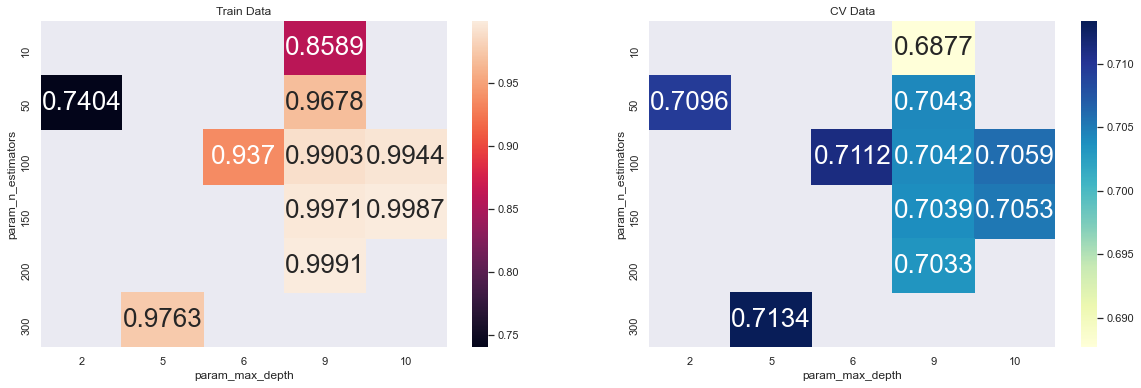

In [19]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(model_tfidf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 26})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 26},cmap="YlGnBu")
ax[0].set_title('Train Data')
ax[1].set_title('CV Data')
plt.show()


[23:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


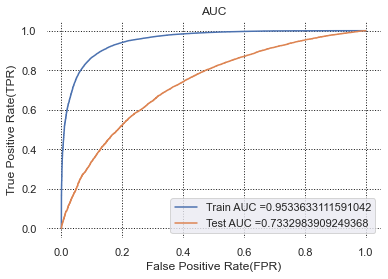

In [20]:
from sklearn.metrics import roc_curve, auc

dt_tfidf_testModel = XGBClassifier(n_estimators=bestnestimators_1,max_depth=bestMaxDepth_1)
dt_tfidf_testModel.fit(X_train_tfidf, y_train)

y_train_pred=dt_tfidf_testModel.predict_proba(X_train_tfidf)[:,1]
predictions_train_set1=dt_tfidf_testModel.predict(X_train_tfidf)

y_test_pred=dt_tfidf_testModel.predict_proba(X_test_tfidf)[:,1]
predictions_test_set1=dt_tfidf_testModel.predict(X_test_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

ax = plt.subplot()
auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)

ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()


In [21]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
[[ 9682  1401]
 [ 6623 55490]]


<AxesSubplot:>

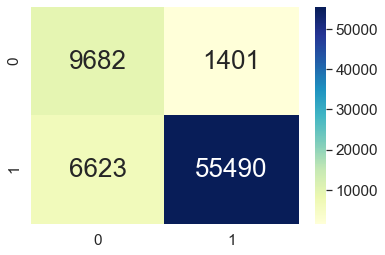

In [22]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))

## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
[[ 3498  1961]
 [ 8958 21635]]


<AxesSubplot:>

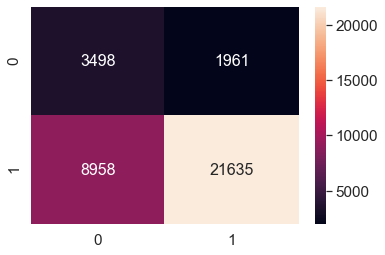

In [23]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

### For Set - 2

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

gbdt = XGBClassifier()
grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
model_tfidf_w2v = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',return_train_score=True,n_jobs=-1)
model_tfidf_w2v.fit(X_train_tfidfw2v, y_train)


[00:11:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                        

In [25]:
train_auc = model_tfidf_w2v.cv_results_['mean_train_score']
train_auc_std = model_tfidf_w2v.cv_results_['std_train_score']
cv_auc = model_tfidf_w2v.cv_results_['mean_test_score']
cv_auc_std = model_tfidf_w2v.cv_results_['std_test_score']
bestMaxDepth_1 = model_tfidf_w2v.best_params_['max_depth']
bestnestimators_1 = model_tfidf_w2v.best_params_['n_estimators']
bestScore_1 = model_tfidf_w2v.best_score_

In [26]:
print("Best max depth: ",bestMaxDepth_1)
print("Best n-estimator: ",bestnestimators_1)

Best max depth:  3
Best n-estimator:  150


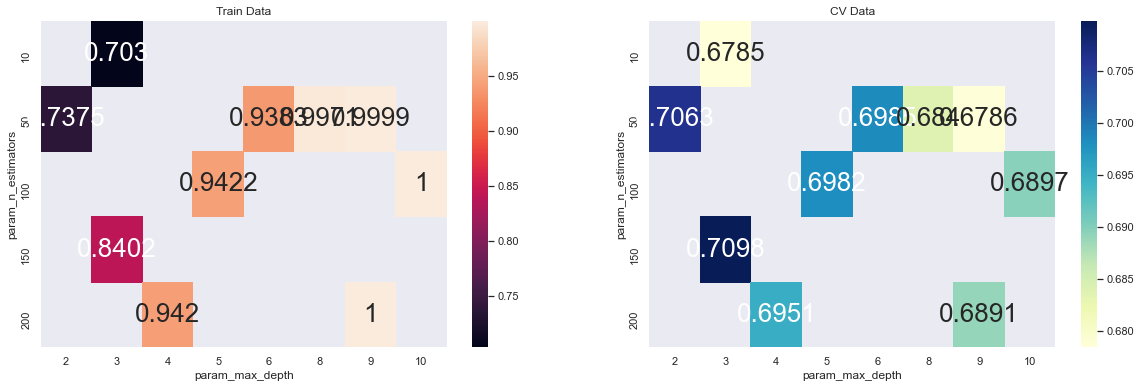

In [27]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(model_tfidf_w2v.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 26})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 26},cmap="YlGnBu")
ax[0].set_title('Train Data')
ax[1].set_title('CV Data')
plt.show()


[00:12:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


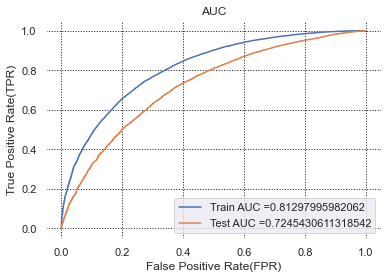

In [28]:
from sklearn.metrics import roc_curve, auc


dt_tfidf_w2v_testModel = XGBClassifier(n_estimators=bestnestimators_1,max_depth=bestMaxDepth_1)
dt_tfidf_w2v_testModel.fit(X_train_tfidfw2v, y_train)

y_train_pred = dt_tfidf_w2v_testModel.predict_proba(X_train_tfidfw2v)[:,1]
predictions_train_set1 = dt_tfidf_w2v_testModel.predict(X_train_tfidfw2v)

y_test_pred = dt_tfidf_w2v_testModel.predict_proba(X_test_tfidfw2v)[:,1]
predictions_test_set1 = dt_tfidf_w2v_testModel.predict(X_test_tfidfw2v)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()


Train confusion matrix
[[ 8077  3006]
 [16041 46072]]


<AxesSubplot:>

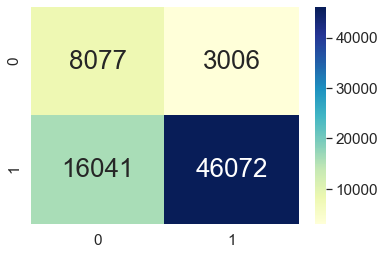

In [29]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))

## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
[[ 4307  1152]
 [14779 15814]]


<AxesSubplot:>

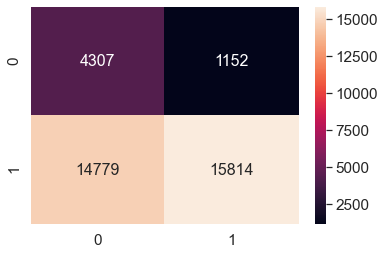

In [30]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [34]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorizer',"Model","HyperParameter (n_estimator , max_depth)","Train AUC","Test AUC"]

x.add_row(["TFIDF","GBDT","(300,5)",0.95,0.73])
x.add_row(["TFIDF","GBDT","(150,3)",0.81,0.72])
print(x)

+------------+-------+------------------------------------------+-----------+----------+
| Vectorizer | Model | HyperParameter (n_estimator , max_depth) | Train AUC | Test AUC |
+------------+-------+------------------------------------------+-----------+----------+
|   TFIDF    |  GBDT |                 (300,5)                  |    0.95   |   0.73   |
|   TFIDF    |  GBDT |                 (150,3)                  |    0.81   |   0.72   |
+------------+-------+------------------------------------------+-----------+----------+
